# Heating Curve Simulation Model

This notebook simulates temperature data from a residential heating system controlled by a Heizkennlinie (heating curve) with Nachtabsenkung (night setback).

## Objective

Generate three datasets with varying noise levels representing different data quality scenarios:
- **Model 1**: Clean data - heating curve clearly visible
- **Model 2**: Moderate noise - clusters visible (day/night/transition)
- **Model 3**: Noisy/realistic - outliers, missing values, sensor issues

## Data Source

Real outdoor temperatures from Berlin (Nov 2023 - Mar 2024) via Open-Meteo API, interpolated to 15-minute resolution.


In [1]:
# Cell 1 - Imports and Configuration

import pandas as pd
import numpy as np
import requests
from datetime import datetime
import matplotlib.pyplot as plt

# Display settings
pd.set_option('display.max_columns', 20)
plt.style.use('seaborn-v0_8-whitegrid')

print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")


pandas: 2.3.3
numpy: 2.4.0


## 1. Data Acquisition

Fetch historical hourly outdoor temperatures for Berlin from Open-Meteo API.
- Location: Berlin (52.52°N, 13.41°E)
- Period: November 2023 - March 2024 (heating season)
- Variable: temperature_2m (°C)


In [4]:
# Cell 2 - Fetch Weather Data from Open-Meteo API

def fetch_weather_data(
    latitude: float = 52.52,
    longitude: float = 13.41,
    start_date: str = "2023-11-01",
    end_date: str = "2024-03-31"
) -> pd.DataFrame:
    """
    Fetch historical hourly temperature data from Open-Meteo API.
    
    Parameters
    ----------
    latitude : float
        Location latitude (default: Berlin)
    longitude : float
        Location longitude (default: Berlin)
    start_date : str
        Start date in YYYY-MM-DD format
    end_date : str
        End date in YYYY-MM-DD format
    
    Returns
    -------
    pd.DataFrame
        DataFrame with datetime index and temperature_2m column
    """
    url = "https://archive-api.open-meteo.com/v1/archive"
    
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": "temperature_2m",
        "timezone": "Europe/Berlin"
    }
    
    response = requests.get(url, params=params)
    response.raise_for_status()
    
    data = response.json()
    
    df = pd.DataFrame({
        "datetime": pd.to_datetime(data["hourly"]["time"]),
        "t_outdoor": data["hourly"]["temperature_2m"]
    })
    
    df = df.set_index("datetime")
    
    return df

# Fetch data
df_weather = fetch_weather_data()

print(f"Records fetched: {len(df_weather)}")
print(f"Date range: {df_weather.index.min()} to {df_weather.index.max()}")
print(f"Missing values: {df_weather['t_outdoor'].isna().sum()}")
print(df_weather.head())


Records fetched: 3648
Date range: 2023-11-01 00:00:00 to 2024-03-31 23:00:00
Missing values: 0
                     t_outdoor
datetime                      
2023-11-01 00:00:00        7.8
2023-11-01 01:00:00        7.2
2023-11-01 02:00:00        7.1
2023-11-01 03:00:00        7.1
2023-11-01 04:00:00        7.0


## 2. Data Interpolation

Convert hourly data to 15-minute resolution and add datetime features for night setback logic.


In [5]:
# Cell 3 - Interpolate to 15-minute Resolution

def interpolate_to_15min(df: pd.DataFrame, method: str = "linear") -> pd.DataFrame:
    """
    Interpolate hourly data to 15-minute resolution.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with datetime index and temperature column
    method : str
        Interpolation method ('linear', 'cubic', 'quadratic')
    
    Returns
    -------
    pd.DataFrame
        DataFrame with 15-minute resolution
    """
    # Create 15-minute index
    new_index = pd.date_range(
        start=df.index.min(),
        end=df.index.max(),
        freq="15min"
    )
    
    # Reindex and interpolate
    df_15min = df.reindex(new_index)
    df_15min = df_15min.interpolate(method=method)
    df_15min.index.name = "datetime"
    
    # Add datetime features
    df_15min["hour"] = df_15min.index.hour
    df_15min["day_of_week"] = df_15min.index.dayofweek
    df_15min["month"] = df_15min.index.month
    df_15min["is_weekend"] = df_15min["day_of_week"].isin([5, 6])
    
    return df_15min

# Apply interpolation
df = interpolate_to_15min(df_weather)

print(f"Records after interpolation: {len(df)}")
print(f"Expected records: {3648 * 4} (hourly * 4)")
print(f"Missing values: {df['t_outdoor'].isna().sum()}")
print(df.head(8))


Records after interpolation: 14589
Expected records: 14592 (hourly * 4)
Missing values: 0
                     t_outdoor  hour  day_of_week  month  is_weekend
datetime                                                            
2023-11-01 00:00:00      7.800     0            2     11       False
2023-11-01 00:15:00      7.650     0            2     11       False
2023-11-01 00:30:00      7.500     0            2     11       False
2023-11-01 00:45:00      7.350     0            2     11       False
2023-11-01 01:00:00      7.200     1            2     11       False
2023-11-01 01:15:00      7.175     1            2     11       False
2023-11-01 01:30:00      7.150     1            2     11       False
2023-11-01 01:45:00      7.125     1            2     11       False


## 3. Data Validation

Verify temperature ranges and distribution match expected Berlin winter conditions.


In [6]:
# Cell 4 - Data Validation

# Summary statistics by month
stats_by_month = df.groupby("month")["t_outdoor"].agg(["mean", "std", "min", "max", "count"])
stats_by_month.index = stats_by_month.index.map({11: "Nov", 12: "Dec", 1: "Jan", 2: "Feb", 3: "Mar"})
print("Temperature Statistics by Month (°C):")
print(stats_by_month.round(1))

# Overall statistics
print(f"\nOverall range: {df['t_outdoor'].min():.1f}°C to {df['t_outdoor'].max():.1f}°C")
print(f"Overall mean: {df['t_outdoor'].mean():.1f}°C")

# Validate expected ranges for Berlin winter
assert df["t_outdoor"].min() > -20, "Minimum temp below expected range"
assert df["t_outdoor"].max() < 25, "Maximum temp above expected range"
print("\nValidation passed: temperatures within expected Berlin winter range")


Temperature Statistics by Month (°C):
       mean  std   min   max  count
month                              
Jan     1.2  4.6 -10.6  10.6   2976
Feb     6.6  3.2  -2.5  15.6   2784
Mar     7.5  4.3  -2.5  21.7   2973
Nov     5.5  4.7  -7.9  14.4   2880
Dec     3.7  4.1  -7.8  10.6   2976

Overall range: -10.6°C to 21.7°C
Overall mean: 4.9°C

Validation passed: temperatures within expected Berlin winter range


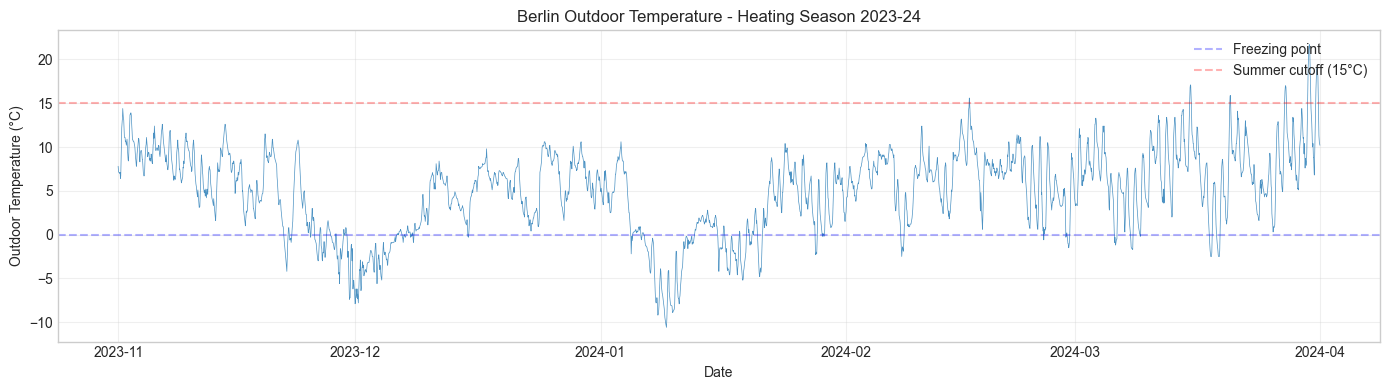

Days below freezing: 25 days
Days above summer cutoff (15°C): 1 days


In [7]:
# Cell 5 - Outdoor Temperature Time Series

fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(df.index, df["t_outdoor"], linewidth=0.5, alpha=0.8)
ax.axhline(y=0, color="blue", linestyle="--", alpha=0.3, label="Freezing point")
ax.axhline(y=15, color="red", linestyle="--", alpha=0.3, label="Summer cutoff (15°C)")

ax.set_xlabel("Date")
ax.set_ylabel("Outdoor Temperature (°C)")
ax.set_title("Berlin Outdoor Temperature - Heating Season 2023-24")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Days below freezing: {(df['t_outdoor'] < 0).sum() / 4 / 24:.0f} days")
print(f"Days above summer cutoff (15°C): {(df['t_outdoor'] > 15).sum() / 4 / 24:.0f} days")


## 4. Heating Curve (Heizkennlinie)

The heating curve defines the relationship between outdoor temperature and flow temperature (Vorlauftemperatur).

### Formula

$$T_{Vorlauf} = T_{base} + K \cdot (T_{room} - T_{outdoor})$$

Where:
- $T_{base}$: Base flow temperature when outdoor = room temp
- $K$: Curve slope (Neigung/Steilheit)
- $T_{room}$: Target room temperature
- $T_{outdoor}$: Measured outdoor temperature

### Industry Reference Values

| Building Type | Slope (K) | Source |
|---------------|-----------|--------|
| Heat pumps / floor heating | 0.2 - 0.5 | Viessmann |
| Well-insulated + radiators | 1.0 - 1.2 | Viessmann |
| Older buildings + radiators | 1.4 - 1.6 | Viessmann |
| Factory default (Viessmann) | 1.4 | Viessmann |

### Parameters Used in This Simulation

| Parameter | Value | Rationale |
|-----------|-------|-----------|
| Slope (K) | 1.4 | Factory default, typical older building |
| Room target (day) | 20°C | German residential standard |
| Room target (night) | 16°C | Typical 4K night setback |
| Base temp | 20°C | Flow temp when outdoor = room temp |
| Summer cutoff | 15°C | Heating off above this outdoor temp |
| Night hours | 22:00 - 06:00 | Typical residential schedule |

**Sources:** 
- [Viessmann Heizkurve Guide](https://www.viessmann.de/de/wissen/anleitungen-und-tipps/heizkurve-einstellen.html)
- [Energie-Experten Heizkurve](https://www.energie-experten.org/heizung/heizungstechnik/heizungssteuerung/heizkurve)

**Note:** Sprint 3 will include a Streamlit app where these parameters are configurable to explore different scenarios.


In [8]:
# Cell 6 - Heating Curve Configuration

# Configurable parameters (Sprint 3: will be Streamlit inputs)
CONFIG = {
    # Heating curve parameters
    "slope": 1.4,                    # K - Neigung/Steilheit
    "t_base": 20.0,                  # °C - Base flow temperature
    "t_room_day": 20.0,              # °C - Room target during day
    "t_room_night": 16.0,            # °C - Room target during night (4K setback)
    
    # Operating limits
    "t_outdoor_summer_cutoff": 15.0, # °C - Heating off above this
    "t_vorlauf_min": 25.0,           # °C - Minimum flow temperature
    "t_vorlauf_max": 75.0,           # °C - Maximum flow temperature
    
    # Night setback schedule
    "night_start_hour": 22,          # 22:00
    "night_end_hour": 6,             # 06:00
}

print("Heating Curve Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")


Heating Curve Configuration:
  slope: 1.4
  t_base: 20.0
  t_room_day: 20.0
  t_room_night: 16.0
  t_outdoor_summer_cutoff: 15.0
  t_vorlauf_min: 25.0
  t_vorlauf_max: 75.0
  night_start_hour: 22
  night_end_hour: 6


In [9]:
# Cell 7 - Heating Curve Function

def calculate_vorlauf(
    t_outdoor: float,
    t_room: float = CONFIG["t_room_day"],
    slope: float = CONFIG["slope"],
    t_base: float = CONFIG["t_base"],
    t_min: float = CONFIG["t_vorlauf_min"],
    t_max: float = CONFIG["t_vorlauf_max"],
    summer_cutoff: float = CONFIG["t_outdoor_summer_cutoff"]
) -> float:
    """
    Calculate Vorlauftemperatur (flow temperature) based on Heizkennlinie.
    
    Parameters
    ----------
    t_outdoor : float
        Outdoor temperature (°C)
    t_room : float
        Target room temperature (°C)
    slope : float
        Heating curve slope (Neigung/Steilheit)
    t_base : float
        Base flow temperature (°C)
    t_min : float
        Minimum flow temperature (°C)
    t_max : float
        Maximum flow temperature (°C)
    summer_cutoff : float
        Outdoor temp above which heating is off (°C)
    
    Returns
    -------
    float
        Flow temperature (°C), or NaN if heating is off
    """
    # Summer mode: heating off
    if t_outdoor > summer_cutoff:
        return np.nan
    
    # Heating curve formula
    t_vorlauf = t_base + slope * (t_room - t_outdoor)
    
    # Clamp to operating limits
    t_vorlauf = np.clip(t_vorlauf, t_min, t_max)
    
    return t_vorlauf

# Test the function
test_temps = [-10, -5, 0, 5, 10, 15, 20]
print("Heating Curve Test (Day Mode, T_room=20°C):")
print("-" * 40)
for t_out in test_temps:
    t_vor = calculate_vorlauf(t_out)
    status = "OFF" if np.isnan(t_vor) else f"{t_vor:.1f}°C"
    print(f"  T_outdoor: {t_out:3d}°C  →  T_vorlauf: {status}")


Heating Curve Test (Day Mode, T_room=20°C):
----------------------------------------
  T_outdoor: -10°C  →  T_vorlauf: 62.0°C
  T_outdoor:  -5°C  →  T_vorlauf: 55.0°C
  T_outdoor:   0°C  →  T_vorlauf: 48.0°C
  T_outdoor:   5°C  →  T_vorlauf: 41.0°C
  T_outdoor:  10°C  →  T_vorlauf: 34.0°C
  T_outdoor:  15°C  →  T_vorlauf: 27.0°C
  T_outdoor:  20°C  →  T_vorlauf: OFF


In [10]:
# Cell 8 - Night Setback Logic

def is_night_hour(hour: int) -> bool:
    """
    Determine if given hour falls within night setback period.
    
    Night period: 22:00 - 06:00 (crosses midnight)
    """
    night_start = CONFIG["night_start_hour"]
    night_end = CONFIG["night_end_hour"]
    
    # Handle crossing midnight
    if night_start > night_end:
        return hour >= night_start or hour < night_end
    else:
        return night_start <= hour < night_end


def get_room_target(hour: int) -> float:
    """
    Get target room temperature based on time of day.
    
    Returns
    -------
    float
        Target room temperature (°C)
    """
    if is_night_hour(hour):
        return CONFIG["t_room_night"]
    else:
        return CONFIG["t_room_day"]


# Test night setback logic
print("Night Setback Schedule:")
print("-" * 50)
for hour in range(24):
    t_room = get_room_target(hour)
    mode = "NIGHT" if is_night_hour(hour) else "DAY"
    print(f"  {hour:02d}:00  →  {mode:5s}  T_room = {t_room:.0f}°C")


Night Setback Schedule:
--------------------------------------------------
  00:00  →  NIGHT  T_room = 16°C
  01:00  →  NIGHT  T_room = 16°C
  02:00  →  NIGHT  T_room = 16°C
  03:00  →  NIGHT  T_room = 16°C
  04:00  →  NIGHT  T_room = 16°C
  05:00  →  NIGHT  T_room = 16°C
  06:00  →  DAY    T_room = 20°C
  07:00  →  DAY    T_room = 20°C
  08:00  →  DAY    T_room = 20°C
  09:00  →  DAY    T_room = 20°C
  10:00  →  DAY    T_room = 20°C
  11:00  →  DAY    T_room = 20°C
  12:00  →  DAY    T_room = 20°C
  13:00  →  DAY    T_room = 20°C
  14:00  →  DAY    T_room = 20°C
  15:00  →  DAY    T_room = 20°C
  16:00  →  DAY    T_room = 20°C
  17:00  →  DAY    T_room = 20°C
  18:00  →  DAY    T_room = 20°C
  19:00  →  DAY    T_room = 20°C
  20:00  →  DAY    T_room = 20°C
  21:00  →  DAY    T_room = 20°C
  22:00  →  NIGHT  T_room = 16°C
  23:00  →  NIGHT  T_room = 16°C


In [11]:
# Cell 9 - Generate Ideal Vorlauf (Model 0)

def apply_heating_curve(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply heating curve with night setback to generate ideal Vorlauf.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with t_outdoor and hour columns
    
    Returns
    -------
    pd.DataFrame
        DataFrame with added t_vorlauf_ideal column
    """
    df = df.copy()
    
    # Get room target based on hour (vectorized)
    df["t_room_target"] = df["hour"].apply(get_room_target)
    
    # Calculate Vorlauf (vectorized)
    df["t_vorlauf_ideal"] = df.apply(
        lambda row: calculate_vorlauf(
            t_outdoor=row["t_outdoor"],
            t_room=row["t_room_target"]
        ),
        axis=1
    )
    
    # Add mode indicator
    df["is_night"] = df["hour"].apply(is_night_hour)
    
    return df

# Apply to dataset
df = apply_heating_curve(df)

# Summary
print("Ideal Vorlauf (Model 0) Generated:")
print(f"  Total records: {len(df)}")
print(f"  Heating ON: {df['t_vorlauf_ideal'].notna().sum()} ({df['t_vorlauf_ideal'].notna().mean()*100:.1f}%)")
print(f"  Heating OFF (summer): {df['t_vorlauf_ideal'].isna().sum()}")
print(f"\nVorlauf Statistics (when heating ON):")
print(df["t_vorlauf_ideal"].describe().round(1))


Ideal Vorlauf (Model 0) Generated:
  Total records: 14589
  Heating ON: 14456 (99.1%)
  Heating OFF (summer): 133

Vorlauf Statistics (when heating ON):
count    14456.0
mean        39.5
std          6.6
min         25.0
25%         34.6
50%         38.5
75%         43.9
max         62.8
Name: t_vorlauf_ideal, dtype: float64


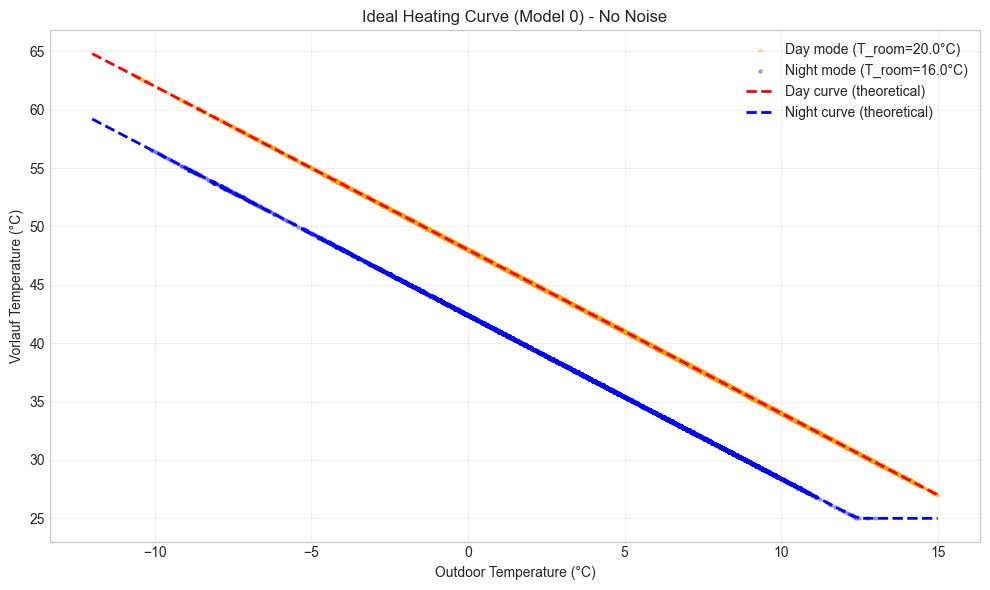

Day mode records: 9595
Night mode records: 4861
Figure saved: outputs/figures/model_0_ideal_heating_curve.png


In [13]:
# Cell 10 - Scatter Plot: Ideal Heating Curve (Model 0)

import os

# Create output directory
output_dir = "outputs/figures"
os.makedirs(output_dir, exist_ok=True)

fig, ax = plt.subplots(figsize=(10, 6))

# Separate day and night data
df_day = df[(~df["is_night"]) & (df["t_vorlauf_ideal"].notna())]
df_night = df[(df["is_night"]) & (df["t_vorlauf_ideal"].notna())]

# Scatter plot
ax.scatter(df_day["t_outdoor"], df_day["t_vorlauf_ideal"], 
           alpha=0.3, s=5, c="orange", label=f"Day mode (T_room={CONFIG['t_room_day']}°C)")
ax.scatter(df_night["t_outdoor"], df_night["t_vorlauf_ideal"], 
           alpha=0.3, s=5, c="blue", label=f"Night mode (T_room={CONFIG['t_room_night']}°C)")

# Reference lines (theoretical curves)
t_out_range = np.linspace(-12, 15, 100)
t_vor_day = [calculate_vorlauf(t, t_room=CONFIG["t_room_day"]) for t in t_out_range]
t_vor_night = [calculate_vorlauf(t, t_room=CONFIG["t_room_night"]) for t in t_out_range]

ax.plot(t_out_range, t_vor_day, 'r--', linewidth=2, label="Day curve (theoretical)")
ax.plot(t_out_range, t_vor_night, 'b--', linewidth=2, label="Night curve (theoretical)")

ax.set_xlabel("Outdoor Temperature (°C)")
ax.set_ylabel("Vorlauf Temperature (°C)")
ax.set_title("Ideal Heating Curve (Model 0) - No Noise")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{output_dir}/model_0_ideal_heating_curve.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Day mode records: {len(df_day)}")
print(f"Night mode records: {len(df_night)}")
print(f"Figure saved: {output_dir}/model_0_ideal_heating_curve.png")


## 5. Noise Models

Three datasets with progressively degraded data quality to simulate real-world sensor scenarios.

| Model | Noise Level | Characteristics | Use Case |
|-------|-------------|-----------------|----------|
| Model 1 | Low | Gaussian noise (σ=1.5°C) | Algorithm validation |
| Model 2 | Moderate | Higher noise + DHW spikes | Robust algorithm testing |
| Model 3 | Realistic | High noise + missing values + outliers | Production-like conditions |

### Noise Configuration


In [14]:
# Cell 11 - Noise Model Configuration

NOISE_CONFIG = {
    "model_1": {
        "name": "Clean Data",
        "gaussian_sigma": 1.5,        # °C
        "dhw_spike_probability": 0.0,
        "dhw_spike_magnitude": 0,
        "missing_rate": 0.0,
        "outlier_rate": 0.0,
        "stuck_sensor_rate": 0.0,
    },
    "model_2": {
        "name": "Moderate Noise",
        "gaussian_sigma": 3.5,        # °C
        "dhw_spike_probability": 0.02, # 2% of readings
        "dhw_spike_magnitude": 12,     # +12°C spike
        "missing_rate": 0.0,
        "outlier_rate": 0.005,         # 0.5% outliers
        "stuck_sensor_rate": 0.0,
    },
    "model_3": {
        "name": "Noisy/Realistic",
        "gaussian_sigma": 5.0,        # °C
        "dhw_spike_probability": 0.03, # 3% of readings
        "dhw_spike_magnitude": 15,     # +15°C spike
        "missing_rate": 0.05,          # 5% missing
        "outlier_rate": 0.015,         # 1.5% outliers
        "stuck_sensor_rate": 0.01,     # 1% stuck values
    },
}

print("Noise Model Configuration:")
print("-" * 60)
for model, config in NOISE_CONFIG.items():
    print(f"\n{model.upper()}: {config['name']}")
    for key, value in config.items():
        if key != "name":
            print(f"  {key}: {value}")


Noise Model Configuration:
------------------------------------------------------------

MODEL_1: Clean Data
  gaussian_sigma: 1.5
  dhw_spike_probability: 0.0
  dhw_spike_magnitude: 0
  missing_rate: 0.0
  outlier_rate: 0.0
  stuck_sensor_rate: 0.0

MODEL_2: Moderate Noise
  gaussian_sigma: 3.5
  dhw_spike_probability: 0.02
  dhw_spike_magnitude: 12
  missing_rate: 0.0
  outlier_rate: 0.005
  stuck_sensor_rate: 0.0

MODEL_3: Noisy/Realistic
  gaussian_sigma: 5.0
  dhw_spike_probability: 0.03
  dhw_spike_magnitude: 15
  missing_rate: 0.05
  outlier_rate: 0.015
  stuck_sensor_rate: 0.01


In [15]:
# Cell 12 - Noise Application Function

def apply_noise(
    df: pd.DataFrame,
    model_config: dict,
    random_seed: int = 42
) -> pd.DataFrame:
    """
    Apply noise to ideal Vorlauf data based on model configuration.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with t_vorlauf_ideal column
    model_config : dict
        Noise configuration dictionary
    random_seed : int
        Random seed for reproducibility
    
    Returns
    -------
    pd.DataFrame
        DataFrame with added t_vorlauf_noisy column
    """
    np.random.seed(random_seed)
    df = df.copy()
    
    # Start with ideal values
    noisy = df["t_vorlauf_ideal"].copy()
    n = len(noisy)
    
    # 1. Gaussian noise
    if model_config["gaussian_sigma"] > 0:
        noise = np.random.normal(0, model_config["gaussian_sigma"], n)
        noisy = noisy + noise
    
    # 2. DHW spikes (domestic hot water interference)
    if model_config["dhw_spike_probability"] > 0:
        spike_mask = np.random.random(n) < model_config["dhw_spike_probability"]
        noisy[spike_mask] = noisy[spike_mask] + model_config["dhw_spike_magnitude"]
    
    # 3. Outliers (random extreme values)
    if model_config["outlier_rate"] > 0:
        outlier_mask = np.random.random(n) < model_config["outlier_rate"]
        outlier_direction = np.random.choice([-1, 1], size=n)
        noisy[outlier_mask] = noisy[outlier_mask] + outlier_direction[outlier_mask] * 20
    
    # 4. Missing values
    if model_config["missing_rate"] > 0:
        missing_mask = np.random.random(n) < model_config["missing_rate"]
        noisy[missing_mask] = np.nan
    
    # 5. Stuck sensor values (repeat previous value)
    if model_config["stuck_sensor_rate"] > 0:
        stuck_mask = np.random.random(n) < model_config["stuck_sensor_rate"]
        for i in range(1, n):
            if stuck_mask[i] and not np.isnan(noisy.iloc[i-1]):
                noisy.iloc[i] = noisy.iloc[i-1]
    
    # Clamp to reasonable range (sensor limits)
    noisy = noisy.clip(lower=0, upper=100)
    
    df["t_vorlauf_noisy"] = noisy
    
    return df


In [16]:
# Cell 13 - Model 1: Clean Data

df_model1 = apply_noise(df, NOISE_CONFIG["model_1"], random_seed=42)

# Rename column for clarity
df_model1 = df_model1.rename(columns={"t_vorlauf_noisy": "t_vorlauf_model1"})

print("Model 1: Clean Data")
print(f"  Records: {len(df_model1)}")
print(f"  Missing: {df_model1['t_vorlauf_model1'].isna().sum()}")
print(f"\nStatistics:")
print(df_model1["t_vorlauf_model1"].describe().round(1))


Model 1: Clean Data
  Records: 14589
  Missing: 133

Statistics:
count    14456.0
mean        39.5
std          6.8
min         22.1
25%         34.5
50%         38.7
75%         43.9
max         65.5
Name: t_vorlauf_model1, dtype: float64


In [17]:
# Cell 14 - Model 2: Moderate Noise

df_model2 = apply_noise(df, NOISE_CONFIG["model_2"], random_seed=43)

# Rename column for clarity
df_model2 = df_model2.rename(columns={"t_vorlauf_noisy": "t_vorlauf_model2"})

# Count noise effects
dhw_spikes = (df_model2["t_vorlauf_model2"] > df["t_vorlauf_ideal"] + 10).sum()
outliers = ((df_model2["t_vorlauf_model2"] > 80) | (df_model2["t_vorlauf_model2"] < 10)).sum()

print("Model 2: Moderate Noise")
print(f"  Records: {len(df_model2)}")
print(f"  Missing: {df_model2['t_vorlauf_model2'].isna().sum()}")
print(f"  Approx DHW spikes: {dhw_spikes}")
print(f"  Approx outliers: {outliers}")
print(f"\nStatistics:")
print(df_model2["t_vorlauf_model2"].describe().round(1))


Model 2: Moderate Noise
  Records: 14589
  Missing: 133
  Approx DHW spikes: 280
  Approx outliers: 4

Statistics:
count    14456.0
mean        39.7
std          7.8
min          1.8
25%         34.2
50%         39.0
75%         44.7
max         75.7
Name: t_vorlauf_model2, dtype: float64


In [18]:
# Cell 15 - Model 3: Noisy/Realistic

df_model3 = apply_noise(df, NOISE_CONFIG["model_3"], random_seed=44)

# Rename column for clarity
df_model3 = df_model3.rename(columns={"t_vorlauf_noisy": "t_vorlauf_model3"})

# Count noise effects
missing_from_noise = df_model3["t_vorlauf_model3"].isna().sum() - 133  # subtract summer cutoff
dhw_spikes = (df_model3["t_vorlauf_model3"] > df["t_vorlauf_ideal"] + 10).sum()
outliers = ((df_model3["t_vorlauf_model3"] > 80) | (df_model3["t_vorlauf_model3"] < 10)).sum()

print("Model 3: Noisy/Realistic")
print(f"  Records: {len(df_model3)}")
print(f"  Missing (total): {df_model3['t_vorlauf_model3'].isna().sum()}")
print(f"  Missing (from noise): ~{missing_from_noise}")
print(f"  Approx DHW spikes: {dhw_spikes}")
print(f"  Approx outliers: {outliers}")
print(f"\nStatistics:")
print(df_model3["t_vorlauf_model3"].describe().round(1))


Model 3: Noisy/Realistic
  Records: 14589
  Missing (total): 883
  Missing (from noise): ~750
  Approx DHW spikes: 744
  Approx outliers: 8

Statistics:
count    13706.0
mean        39.8
std          9.0
min          4.1
25%         33.6
50%         39.2
75%         45.5
max         79.8
Name: t_vorlauf_model3, dtype: float64


In [19]:
# Cell 16 - Consolidate All Models

# Add model columns to main dataframe
df["t_vorlauf_model1"] = df_model1["t_vorlauf_model1"]
df["t_vorlauf_model2"] = df_model2["t_vorlauf_model2"]
df["t_vorlauf_model3"] = df_model3["t_vorlauf_model3"]

# Summary comparison
summary = pd.DataFrame({
    "Model 0 (Ideal)": df["t_vorlauf_ideal"].describe(),
    "Model 1 (Clean)": df["t_vorlauf_model1"].describe(),
    "Model 2 (Moderate)": df["t_vorlauf_model2"].describe(),
    "Model 3 (Noisy)": df["t_vorlauf_model3"].describe(),
}).round(1)

print("Model Comparison Summary:")
print(summary)
print(f"\nDataFrame columns: {list(df.columns)}")


Model Comparison Summary:
       Model 0 (Ideal)  Model 1 (Clean)  Model 2 (Moderate)  Model 3 (Noisy)
count          14456.0          14456.0             14456.0          13706.0
mean              39.5             39.5                39.7             39.8
std                6.6              6.8                 7.8              9.0
min               25.0             22.1                 1.8              4.1
25%               34.6             34.5                34.2             33.6
50%               38.5             38.7                39.0             39.2
75%               43.9             43.9                44.7             45.5
max               62.8             65.5                75.7             79.8

DataFrame columns: ['t_outdoor', 'hour', 'day_of_week', 'month', 'is_weekend', 't_room_target', 't_vorlauf_ideal', 'is_night', 't_vorlauf_model1', 't_vorlauf_model2', 't_vorlauf_model3']


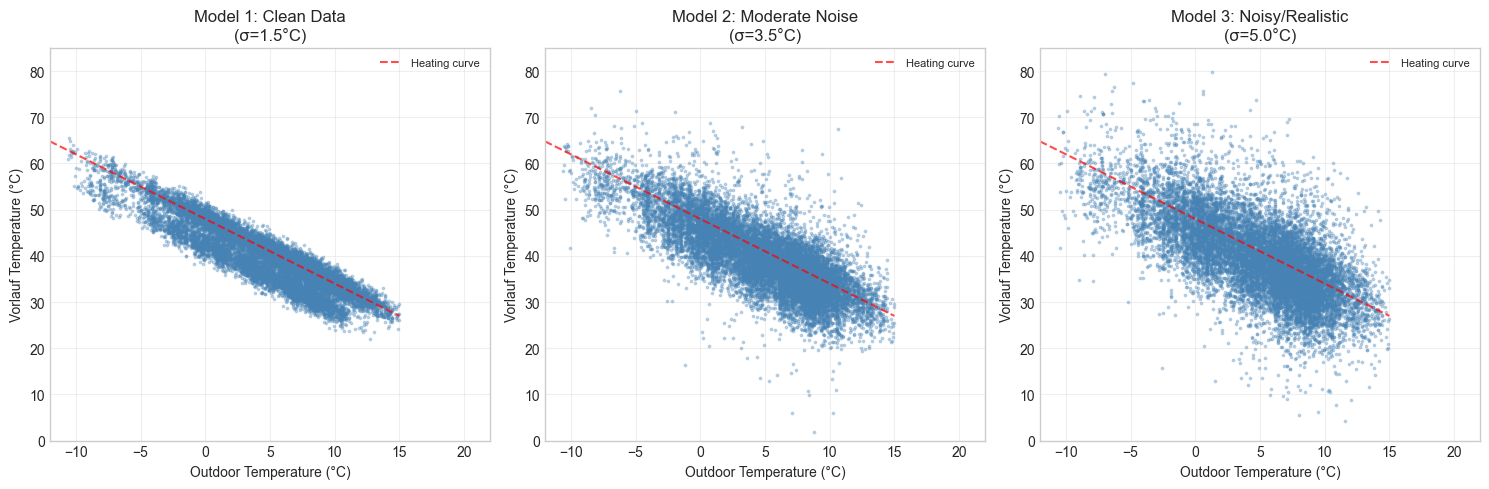

Figure saved: outputs/figures/models_1_2_3_comparison.png


In [21]:
# Cell 17 - Scatter Plots: Model Comparison

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = [
    ("t_vorlauf_model1", "Model 1: Clean Data", NOISE_CONFIG["model_1"]),
    ("t_vorlauf_model2", "Model 2: Moderate Noise", NOISE_CONFIG["model_2"]),
    ("t_vorlauf_model3", "Model 3: Noisy/Realistic", NOISE_CONFIG["model_3"]),
]

for ax, (col, title, config) in zip(axes, models):
    # Filter valid data
    mask = df[col].notna()
    
    # Scatter plot
    ax.scatter(df.loc[mask, "t_outdoor"], df.loc[mask, col], 
               alpha=0.3, s=3, c="steelblue")
    
    # Reference lines (theoretical day curve)
    t_out_range = np.linspace(-12, 15, 100)
    t_vor_day = [calculate_vorlauf(t, t_room=CONFIG["t_room_day"]) for t in t_out_range]
    ax.plot(t_out_range, t_vor_day, 'r--', linewidth=1.5, alpha=0.7, label="Heating curve")
    
    ax.set_xlabel("Outdoor Temperature (°C)")
    ax.set_ylabel("Vorlauf Temperature (°C)")
    ax.set_title(f"{title}\n(σ={config['gaussian_sigma']}°C)")
    ax.set_xlim(-12, 22)
    ax.set_ylim(0, 85)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right", fontsize=8)

plt.tight_layout()
plt.savefig(f"{output_dir}/models_1_2_3_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Figure saved: {output_dir}/models_1_2_3_comparison.png")


## 6. Time Series Visualization

Two views of the temperature data:
1. **Daily overview**: Full 5-month period resampled to daily mean
2. **Sample week detail**: Coldest week in January at 15-minute resolution


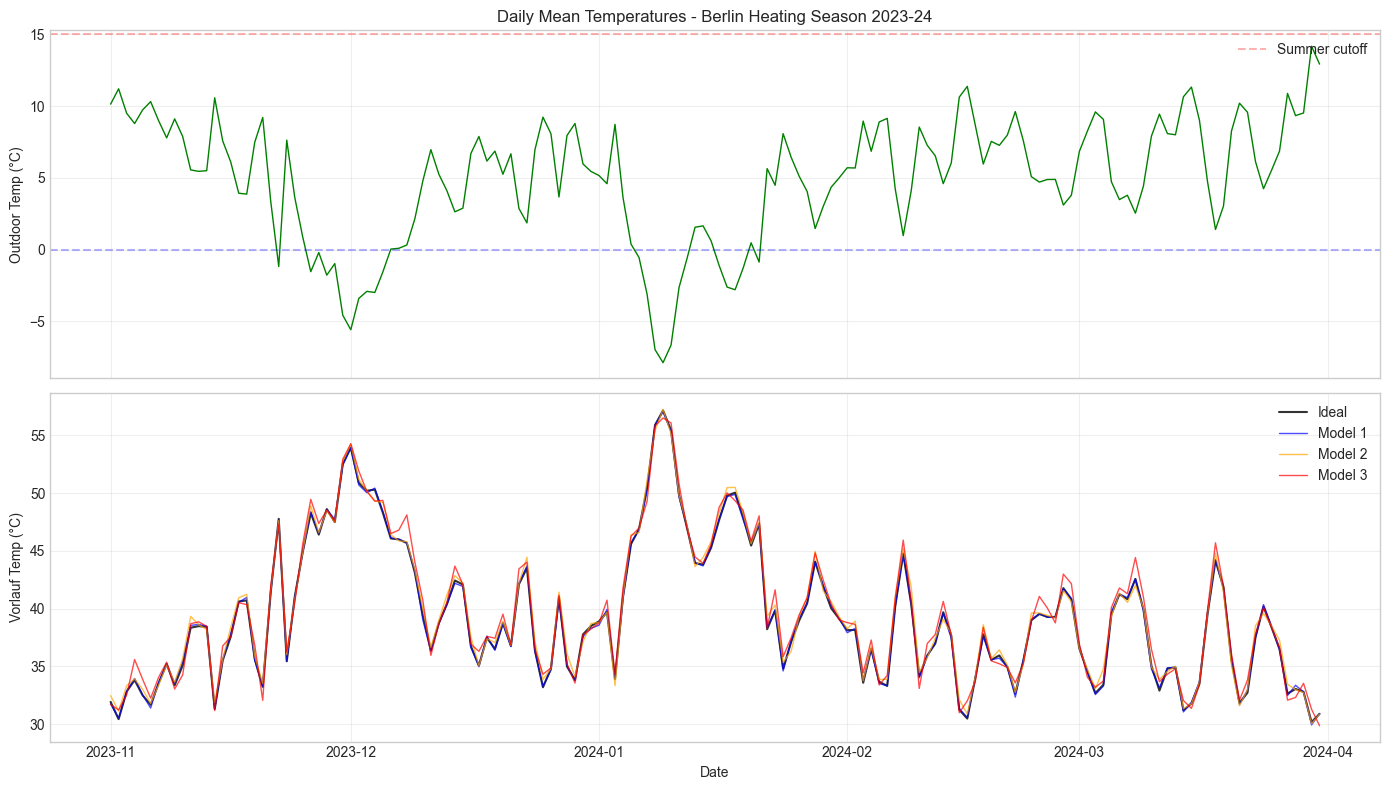

Figure saved: outputs/figures/timeseries_daily_overview.png


In [22]:
# Cell 18 - Time Series: Daily Overview (Full Period)

# Resample to daily statistics
df_daily = df.resample("D").agg({
    "t_outdoor": "mean",
    "t_vorlauf_ideal": "mean",
    "t_vorlauf_model1": "mean",
    "t_vorlauf_model2": "mean",
    "t_vorlauf_model3": "mean",
})

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top: Outdoor temperature
ax1 = axes[0]
ax1.plot(df_daily.index, df_daily["t_outdoor"], color="green", linewidth=1)
ax1.axhline(y=0, color="blue", linestyle="--", alpha=0.3)
ax1.axhline(y=15, color="red", linestyle="--", alpha=0.3, label="Summer cutoff")
ax1.set_ylabel("Outdoor Temp (°C)")
ax1.set_title("Daily Mean Temperatures - Berlin Heating Season 2023-24")
ax1.legend(loc="upper right")
ax1.grid(True, alpha=0.3)

# Bottom: Vorlauf temperatures (all models)
ax2 = axes[1]
ax2.plot(df_daily.index, df_daily["t_vorlauf_ideal"], 
         color="black", linewidth=1.5, label="Ideal", alpha=0.8)
ax2.plot(df_daily.index, df_daily["t_vorlauf_model1"], 
         color="blue", linewidth=1, label="Model 1", alpha=0.7)
ax2.plot(df_daily.index, df_daily["t_vorlauf_model2"], 
         color="orange", linewidth=1, label="Model 2", alpha=0.7)
ax2.plot(df_daily.index, df_daily["t_vorlauf_model3"], 
         color="red", linewidth=1, label="Model 3", alpha=0.7)

ax2.set_xlabel("Date")
ax2.set_ylabel("Vorlauf Temp (°C)")
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{output_dir}/timeseries_daily_overview.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Figure saved: {output_dir}/timeseries_daily_overview.png")


Coldest week: 2024-01-08 to 2024-01-14
Mean outdoor temp: -3.1°C


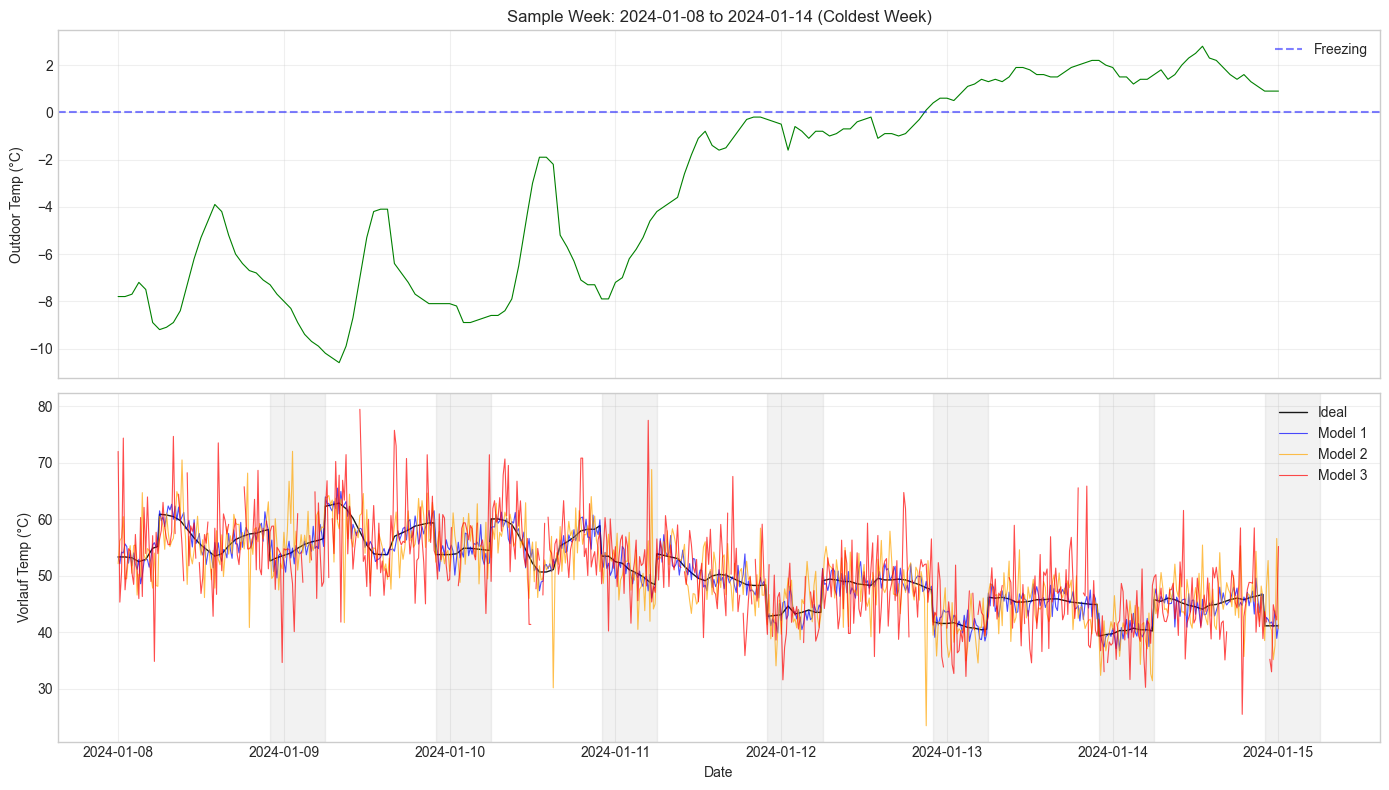

Figure saved: outputs/figures/timeseries_sample_week.png
Records in week: 673


In [23]:
# Cell 18 - Time Series: Sample Week Detail (Coldest Week)

# Find coldest week (lowest mean outdoor temp)
df_weekly_mean = df["t_outdoor"].resample("W").mean()
coldest_week_end = df_weekly_mean.idxmin()
coldest_week_start = coldest_week_end - pd.Timedelta(days=6)

print(f"Coldest week: {coldest_week_start.date()} to {coldest_week_end.date()}")
print(f"Mean outdoor temp: {df_weekly_mean.min():.1f}°C")

# Filter to coldest week
mask = (df.index >= coldest_week_start) & (df.index <= coldest_week_end + pd.Timedelta(days=1))
df_week = df.loc[mask]

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top: Outdoor temperature
ax1 = axes[0]
ax1.plot(df_week.index, df_week["t_outdoor"], color="green", linewidth=0.8)
ax1.axhline(y=0, color="blue", linestyle="--", alpha=0.5, label="Freezing")
ax1.set_ylabel("Outdoor Temp (°C)")
ax1.set_title(f"Sample Week: {coldest_week_start.date()} to {coldest_week_end.date()} (Coldest Week)")
ax1.legend(loc="upper right")
ax1.grid(True, alpha=0.3)

# Bottom: Vorlauf temperatures (all models)
ax2 = axes[1]
ax2.plot(df_week.index, df_week["t_vorlauf_ideal"], 
         color="black", linewidth=1, label="Ideal", alpha=0.9)
ax2.plot(df_week.index, df_week["t_vorlauf_model1"], 
         color="blue", linewidth=0.8, label="Model 1", alpha=0.7)
ax2.plot(df_week.index, df_week["t_vorlauf_model2"], 
         color="orange", linewidth=0.8, label="Model 2", alpha=0.7)
ax2.plot(df_week.index, df_week["t_vorlauf_model3"], 
         color="red", linewidth=0.8, label="Model 3", alpha=0.7)

ax2.set_xlabel("Date")
ax2.set_ylabel("Vorlauf Temp (°C)")
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.3)

# Add day/night shading
for day in pd.date_range(coldest_week_start, coldest_week_end, freq="D"):
    night_start = day + pd.Timedelta(hours=22)
    night_end = day + pd.Timedelta(hours=30)  # 6am next day
    ax2.axvspan(night_start, night_end, alpha=0.1, color="gray")

plt.tight_layout()
plt.savefig(f"{output_dir}/timeseries_sample_week.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Figure saved: {output_dir}/timeseries_sample_week.png")
print(f"Records in week: {len(df_week)}")


## 7. Full Period Time Series

Daily resampled overview showing the complete heating season.


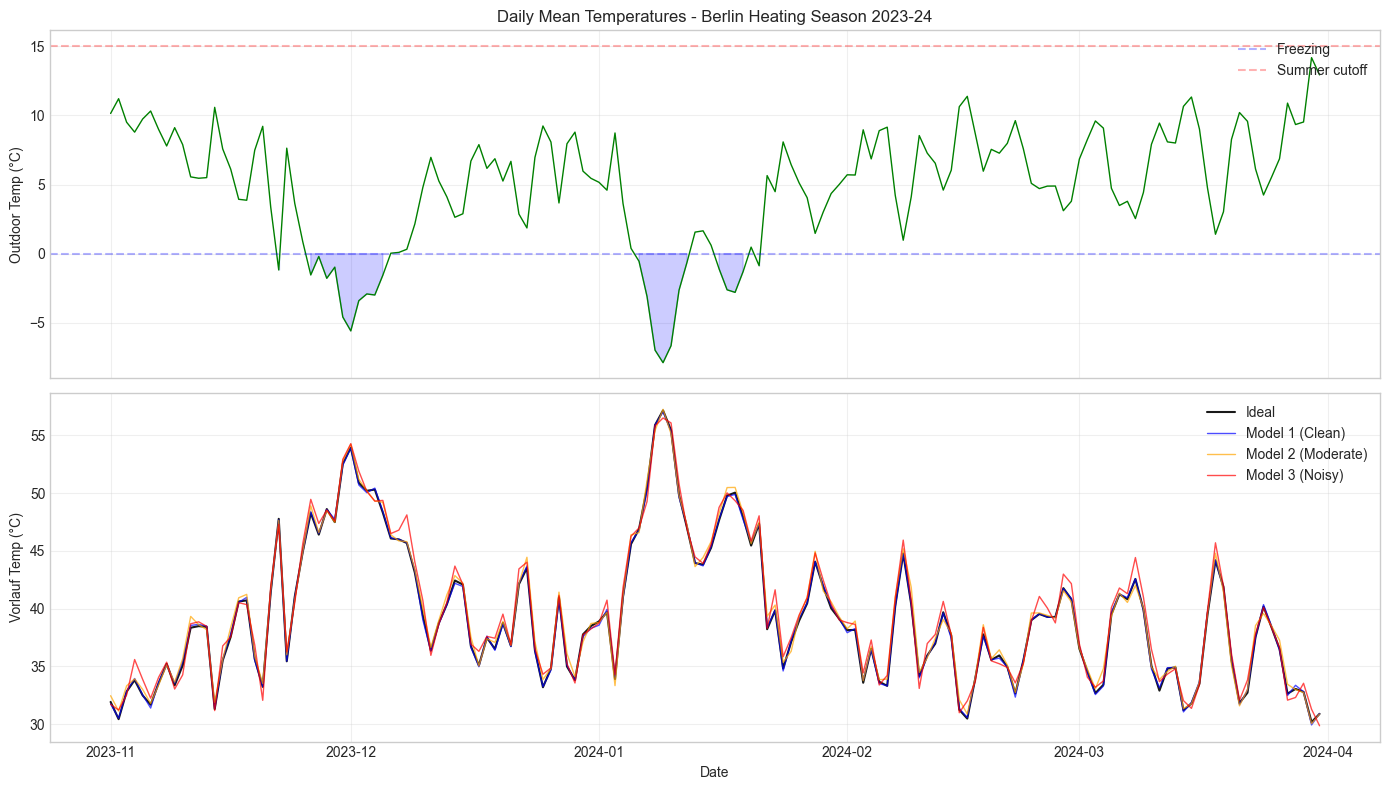

Figure saved: outputs/figures/timeseries_daily_overview.png


In [24]:
# Cell 19 - Time Series: Daily Overview (Full Period)

# Resample to daily statistics
df_daily = df.resample("D").agg({
    "t_outdoor": "mean",
    "t_vorlauf_ideal": "mean",
    "t_vorlauf_model1": "mean",
    "t_vorlauf_model2": "mean",
    "t_vorlauf_model3": "mean",
})

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top: Outdoor temperature
ax1 = axes[0]
ax1.plot(df_daily.index, df_daily["t_outdoor"], color="green", linewidth=1)
ax1.axhline(y=0, color="blue", linestyle="--", alpha=0.3, label="Freezing")
ax1.axhline(y=15, color="red", linestyle="--", alpha=0.3, label="Summer cutoff")
ax1.fill_between(df_daily.index, df_daily["t_outdoor"], 0, 
                  where=(df_daily["t_outdoor"] < 0), alpha=0.2, color="blue")
ax1.set_ylabel("Outdoor Temp (°C)")
ax1.set_title("Daily Mean Temperatures - Berlin Heating Season 2023-24")
ax1.legend(loc="upper right")
ax1.grid(True, alpha=0.3)

# Bottom: Vorlauf temperatures (all models)
ax2 = axes[1]
ax2.plot(df_daily.index, df_daily["t_vorlauf_ideal"], 
         color="black", linewidth=1.5, label="Ideal", alpha=0.9)
ax2.plot(df_daily.index, df_daily["t_vorlauf_model1"], 
         color="blue", linewidth=1, label="Model 1 (Clean)", alpha=0.7)
ax2.plot(df_daily.index, df_daily["t_vorlauf_model2"], 
         color="orange", linewidth=1, label="Model 2 (Moderate)", alpha=0.7)
ax2.plot(df_daily.index, df_daily["t_vorlauf_model3"], 
         color="red", linewidth=1, label="Model 3 (Noisy)", alpha=0.7)

ax2.set_xlabel("Date")
ax2.set_ylabel("Vorlauf Temp (°C)")
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{output_dir}/timeseries_daily_overview.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Figure saved: {output_dir}/timeseries_daily_overview.png")


## 8. Domain Validation

Validate simulation outputs against industry benchmarks from German heating systems.


In [25]:
# Cell 20 - Domain Validation

print("=" * 60)
print("DOMAIN VALIDATION: Heating Curve Simulation")
print("=" * 60)

# Benchmark 1: Vorlauf at 4°C outdoor (industry: ~60-65°C)
mask_4c = (df["t_outdoor"] >= 3.5) & (df["t_outdoor"] <= 4.5) & (~df["is_night"])
vorlauf_at_4c = df.loc[mask_4c, "t_vorlauf_ideal"].mean()
print(f"\n1. Vorlauf at 4°C outdoor (day mode):")
print(f"   Simulated: {vorlauf_at_4c:.1f}°C")
print(f"   Industry benchmark: 60-65°C (often too high)")
print(f"   Status: {'PASS' if 40 < vorlauf_at_4c < 70 else 'CHECK'}")

# Benchmark 2: Night setback reduction (typical: 4-6K)
mask_0c_day = (df["t_outdoor"] >= -0.5) & (df["t_outdoor"] <= 0.5) & (~df["is_night"])
mask_0c_night = (df["t_outdoor"] >= -0.5) & (df["t_outdoor"] <= 0.5) & (df["is_night"])
vorlauf_day = df.loc[mask_0c_day, "t_vorlauf_ideal"].mean()
vorlauf_night = df.loc[mask_0c_night, "t_vorlauf_ideal"].mean()
night_reduction = vorlauf_day - vorlauf_night
print(f"\n2. Night setback reduction at 0°C outdoor:")
print(f"   Day Vorlauf: {vorlauf_day:.1f}°C")
print(f"   Night Vorlauf: {vorlauf_night:.1f}°C")
print(f"   Reduction: {night_reduction:.1f}K")
print(f"   Expected: 4-6K (based on 4K room temp reduction × slope)")
print(f"   Status: {'PASS' if 3 < night_reduction < 8 else 'CHECK'}")

# Benchmark 3: Vorlauf range
vorlauf_min = df["t_vorlauf_ideal"].min()
vorlauf_max = df["t_vorlauf_ideal"].max()
print(f"\n3. Vorlauf temperature range:")
print(f"   Min: {vorlauf_min:.1f}°C (at summer cutoff)")
print(f"   Max: {vorlauf_max:.1f}°C (coldest outdoor temp)")
print(f"   Expected: 25-75°C for radiator systems")
print(f"   Status: {'PASS' if 20 < vorlauf_min < 35 and 55 < vorlauf_max < 80 else 'CHECK'}")

# Benchmark 4: Heating curve slope verification
# At T_outdoor = -10°C, T_room = 20°C: T_vorlauf = 20 + 1.4 * (20 - (-10)) = 20 + 42 = 62°C
expected_at_minus10 = CONFIG["t_base"] + CONFIG["slope"] * (CONFIG["t_room_day"] - (-10))
mask_minus10 = (df["t_outdoor"] >= -10.5) & (df["t_outdoor"] <= -9.5) & (~df["is_night"])
actual_at_minus10 = df.loc[mask_minus10, "t_vorlauf_ideal"].mean()
print(f"\n4. Heating curve slope verification at -10°C:")
print(f"   Expected (formula): {expected_at_minus10:.1f}°C")
print(f"   Actual (simulated): {actual_at_minus10:.1f}°C")
print(f"   Difference: {abs(expected_at_minus10 - actual_at_minus10):.2f}K")
print(f"   Status: {'PASS' if abs(expected_at_minus10 - actual_at_minus10) < 1 else 'CHECK'}")

print("\n" + "=" * 60)
print("VALIDATION COMPLETE")
print("=" * 60)


DOMAIN VALIDATION: Heating Curve Simulation

1. Vorlauf at 4°C outdoor (day mode):
   Simulated: 42.3°C
   Industry benchmark: 60-65°C (often too high)
   Status: PASS

2. Night setback reduction at 0°C outdoor:
   Day Vorlauf: 47.9°C
   Night Vorlauf: 42.4°C
   Reduction: 5.4K
   Expected: 4-6K (based on 4K room temp reduction × slope)
   Status: PASS

3. Vorlauf temperature range:
   Min: 25.0°C (at summer cutoff)
   Max: 62.8°C (coldest outdoor temp)
   Expected: 25-75°C for radiator systems
   Status: PASS

4. Heating curve slope verification at -10°C:
   Expected (formula): 62.0°C
   Actual (simulated): 62.3°C
   Difference: 0.31K
   Status: PASS

VALIDATION COMPLETE


## 9. Statistical Summary

Comprehensive comparison of all models including noise characteristics.


In [26]:
# Cell 21 - Statistical Summary Table

# Basic statistics
stats_basic = pd.DataFrame({
    "Ideal": df["t_vorlauf_ideal"].describe(),
    "Model 1": df["t_vorlauf_model1"].describe(),
    "Model 2": df["t_vorlauf_model2"].describe(),
    "Model 3": df["t_vorlauf_model3"].describe(),
}).round(2)

# Noise characteristics
noise_stats = pd.DataFrame({
    "Metric": [
        "Gaussian σ (°C)",
        "DHW spike prob (%)",
        "Missing rate (%)",
        "Outlier rate (%)",
        "Actual missing count",
        "Actual std (°C)",
        "Std increase vs ideal (°C)",
    ],
    "Model 1": [
        NOISE_CONFIG["model_1"]["gaussian_sigma"],
        NOISE_CONFIG["model_1"]["dhw_spike_probability"] * 100,
        NOISE_CONFIG["model_1"]["missing_rate"] * 100,
        NOISE_CONFIG["model_1"]["outlier_rate"] * 100,
        df["t_vorlauf_model1"].isna().sum(),
        df["t_vorlauf_model1"].std().round(2),
        (df["t_vorlauf_model1"].std() - df["t_vorlauf_ideal"].std()).round(2),
    ],
    "Model 2": [
        NOISE_CONFIG["model_2"]["gaussian_sigma"],
        NOISE_CONFIG["model_2"]["dhw_spike_probability"] * 100,
        NOISE_CONFIG["model_2"]["missing_rate"] * 100,
        NOISE_CONFIG["model_2"]["outlier_rate"] * 100,
        df["t_vorlauf_model2"].isna().sum(),
        df["t_vorlauf_model2"].std().round(2),
        (df["t_vorlauf_model2"].std() - df["t_vorlauf_ideal"].std()).round(2),
    ],
    "Model 3": [
        NOISE_CONFIG["model_3"]["gaussian_sigma"],
        NOISE_CONFIG["model_3"]["dhw_spike_probability"] * 100,
        NOISE_CONFIG["model_3"]["missing_rate"] * 100,
        NOISE_CONFIG["model_3"]["outlier_rate"] * 100,
        df["t_vorlauf_model3"].isna().sum(),
        df["t_vorlauf_model3"].std().round(2),
        (df["t_vorlauf_model3"].std() - df["t_vorlauf_ideal"].std()).round(2),
    ],
}).set_index("Metric")

print("Basic Statistics (Vorlauf Temperature):")
print(stats_basic)
print("\n" + "=" * 60)
print("\nNoise Characteristics:")
print(noise_stats)


Basic Statistics (Vorlauf Temperature):
          Ideal   Model 1   Model 2   Model 3
count  14456.00  14456.00  14456.00  13706.00
mean      39.47     39.47     39.71     39.84
std        6.63      6.79      7.81      9.02
min       25.00     22.07      1.78      4.14
25%       34.56     34.45     34.21     33.59
50%       38.48     38.65     39.04     39.22
75%       43.87     43.89     44.68     45.51
max       62.84     65.50     75.74     79.83


Noise Characteristics:
                            Model 1  Model 2  Model 3
Metric                                               
Gaussian σ (°C)                1.50     3.50     5.00
DHW spike prob (%)             0.00     2.00     3.00
Missing rate (%)               0.00     0.00     5.00
Outlier rate (%)               0.00     0.50     1.50
Actual missing count         133.00   133.00   883.00
Actual std (°C)                6.79     7.81     9.02
Std increase vs ideal (°C)     0.16     1.18     2.40


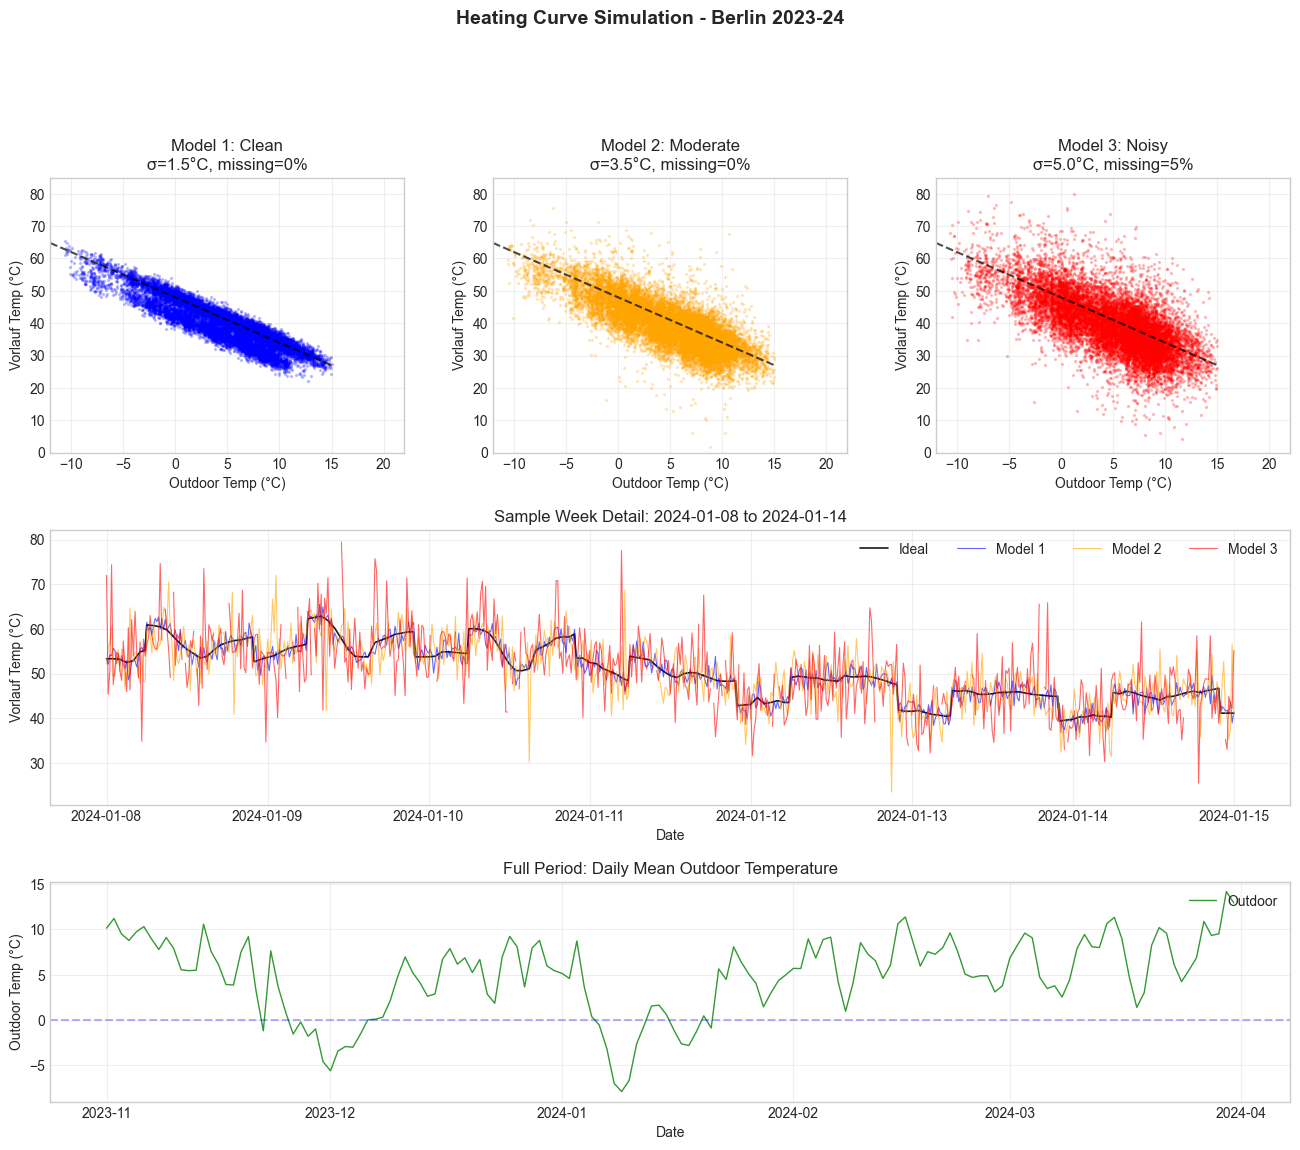

Figure saved: outputs/figures/summary_combined.png


In [27]:
# Cell 22 - Combined Summary Figure (Publication Quality)

fig = plt.figure(figsize=(16, 12))

# Create grid: 2 rows, 3 columns top + 1 wide row bottom
gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 0.8], hspace=0.3, wspace=0.25)

# Top row: Scatter plots for each model
models = [
    ("t_vorlauf_model1", "Model 1: Clean", "blue", NOISE_CONFIG["model_1"]),
    ("t_vorlauf_model2", "Model 2: Moderate", "orange", NOISE_CONFIG["model_2"]),
    ("t_vorlauf_model3", "Model 3: Noisy", "red", NOISE_CONFIG["model_3"]),
]

for i, (col, title, color, config) in enumerate(models):
    ax = fig.add_subplot(gs[0, i])
    mask = df[col].notna()
    ax.scatter(df.loc[mask, "t_outdoor"], df.loc[mask, col], 
               alpha=0.2, s=2, c=color)
    
    # Reference curve
    t_out_range = np.linspace(-12, 15, 100)
    t_vor_day = [calculate_vorlauf(t, t_room=CONFIG["t_room_day"]) for t in t_out_range]
    ax.plot(t_out_range, t_vor_day, 'k--', linewidth=1.5, alpha=0.7)
    
    ax.set_xlabel("Outdoor Temp (°C)")
    ax.set_ylabel("Vorlauf Temp (°C)")
    ax.set_title(f"{title}\nσ={config['gaussian_sigma']}°C, missing={config['missing_rate']*100:.0f}%")
    ax.set_xlim(-12, 22)
    ax.set_ylim(0, 85)
    ax.grid(True, alpha=0.3)

# Middle row: Sample week time series
ax_ts = fig.add_subplot(gs[1, :])
mask = (df.index >= coldest_week_start) & (df.index <= coldest_week_end + pd.Timedelta(days=1))
df_week = df.loc[mask]

ax_ts.plot(df_week.index, df_week["t_vorlauf_ideal"], 
           color="black", linewidth=1.2, label="Ideal", alpha=0.9)
ax_ts.plot(df_week.index, df_week["t_vorlauf_model1"], 
           color="blue", linewidth=0.8, label="Model 1", alpha=0.6)
ax_ts.plot(df_week.index, df_week["t_vorlauf_model2"], 
           color="orange", linewidth=0.8, label="Model 2", alpha=0.6)
ax_ts.plot(df_week.index, df_week["t_vorlauf_model3"], 
           color="red", linewidth=0.8, label="Model 3", alpha=0.6)

ax_ts.set_xlabel("Date")
ax_ts.set_ylabel("Vorlauf Temp (°C)")
ax_ts.set_title(f"Sample Week Detail: {coldest_week_start.date()} to {coldest_week_end.date()}")
ax_ts.legend(loc="upper right", ncol=4)
ax_ts.grid(True, alpha=0.3)

# Bottom row: Daily overview
ax_daily = fig.add_subplot(gs[2, :])
ax_daily.plot(df_daily.index, df_daily["t_outdoor"], 
              color="green", linewidth=1, label="Outdoor", alpha=0.8)
ax_daily.axhline(y=0, color="blue", linestyle="--", alpha=0.3)

ax_daily.set_xlabel("Date")
ax_daily.set_ylabel("Outdoor Temp (°C)")
ax_daily.set_title("Full Period: Daily Mean Outdoor Temperature")
ax_daily.legend(loc="upper right")
ax_daily.grid(True, alpha=0.3)

plt.suptitle("Heating Curve Simulation - Berlin 2023-24", fontsize=14, fontweight="bold", y=1.02)
plt.savefig(f"{output_dir}/summary_combined.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Figure saved: {output_dir}/summary_combined.png")


---

## 10. Alternative Scenario: Low Temperature System (T_vorlauf_max = 55°C)

This scenario simulates a heat-pump-ready or well-optimized building with a lower maximum flow temperature. This reveals the characteristic "S-shape" pattern in heating curve data where temperature clamping occurs at both ends.

**Scenario characteristics:**
- T_vorlauf_max reduced from 75°C to 55°C
- Represents modern/renovated buildings or heat pump systems
- Enables condensing boiler operation (Brennwertnutzung)
- 17% of German buildings already operate in this range

See [DEC-002](plan/DEC-002_vorlauf_max_55C_scenario.md) for full rationale.


In [28]:
# Cell 23 - Low Temperature Scenario Configuration

CONFIG_LOW_TEMP = CONFIG.copy()
CONFIG_LOW_TEMP["t_vorlauf_max"] = 55.0

print("Low Temperature Scenario Configuration:")
print(f"  Original t_vorlauf_max: {CONFIG['t_vorlauf_max']}°C")
print(f"  New t_vorlauf_max: {CONFIG_LOW_TEMP['t_vorlauf_max']}°C")
print(f"\nClamping will occur when T_outdoor < -5°C")
print(f"  Formula: T_vorlauf = 20 + 1.4 × (20 - T_outdoor)")
print(f"  At T_outdoor = -5°C: T_vorlauf = {20 + 1.4 * (20 - (-5)):.1f}°C")
print(f"  At T_outdoor = -10°C: would be {20 + 1.4 * (20 - (-10)):.1f}°C → clamped to 55°C")


Low Temperature Scenario Configuration:
  Original t_vorlauf_max: 75.0°C
  New t_vorlauf_max: 55.0°C

Clamping will occur when T_outdoor < -5°C
  Formula: T_vorlauf = 20 + 1.4 × (20 - T_outdoor)
  At T_outdoor = -5°C: T_vorlauf = 55.0°C
  At T_outdoor = -10°C: would be 62.0°C → clamped to 55°C


In [30]:
# Cell 24 - Generate Low Temperature Scenario

def calculate_vorlauf_low_temp(t_outdoor: float, t_room: float) -> float:
    """Calculate Vorlauf with low-temp configuration."""
    return calculate_vorlauf(
        t_outdoor=t_outdoor,
        t_room=t_room,
        slope=CONFIG_LOW_TEMP["slope"],
        t_base=CONFIG_LOW_TEMP["t_base"],
        t_min=CONFIG_LOW_TEMP["t_vorlauf_min"],
        t_max=CONFIG_LOW_TEMP["t_vorlauf_max"],
        summer_cutoff=CONFIG_LOW_TEMP["t_outdoor_summer_cutoff"]
    )

# Generate ideal Vorlauf with low-temp limits
df["t_vorlauf_lowtemp_ideal"] = df.apply(
    lambda row: calculate_vorlauf_low_temp(row["t_outdoor"], row["t_room_target"]),
    axis=1
)

# Create temporary dataframe for noise application
df_temp = df[["t_outdoor", "hour", "t_vorlauf_lowtemp_ideal"]].copy()
df_temp = df_temp.rename(columns={"t_vorlauf_lowtemp_ideal": "t_vorlauf_ideal"})

# Apply noise models
df_lt_model1 = apply_noise(df_temp, NOISE_CONFIG["model_1"], random_seed=42)
df["t_vorlauf_lowtemp_m1"] = df_lt_model1["t_vorlauf_noisy"]

df_lt_model2 = apply_noise(df_temp, NOISE_CONFIG["model_2"], random_seed=43)
df["t_vorlauf_lowtemp_m2"] = df_lt_model2["t_vorlauf_noisy"]

df_lt_model3 = apply_noise(df_temp, NOISE_CONFIG["model_3"], random_seed=44)
df["t_vorlauf_lowtemp_m3"] = df_lt_model3["t_vorlauf_noisy"]

# Count clamped records
clamped_upper = (df["t_vorlauf_lowtemp_ideal"] == CONFIG_LOW_TEMP["t_vorlauf_max"]).sum()
clamped_lower = (df["t_vorlauf_lowtemp_ideal"] == CONFIG_LOW_TEMP["t_vorlauf_min"]).sum()

print("Low Temperature Scenario Generated:")
print(f"  Records clamped at max ({CONFIG_LOW_TEMP['t_vorlauf_max']}°C): {clamped_upper}")
print(f"  Records clamped at min ({CONFIG_LOW_TEMP['t_vorlauf_min']}°C): {clamped_lower}")
print(f"  Records in linear range: {len(df) - clamped_upper - clamped_lower - 133}")


Low Temperature Scenario Generated:
  Records clamped at max (55.0°C): 253
  Records clamped at min (25.0°C): 3
  Records in linear range: 14200


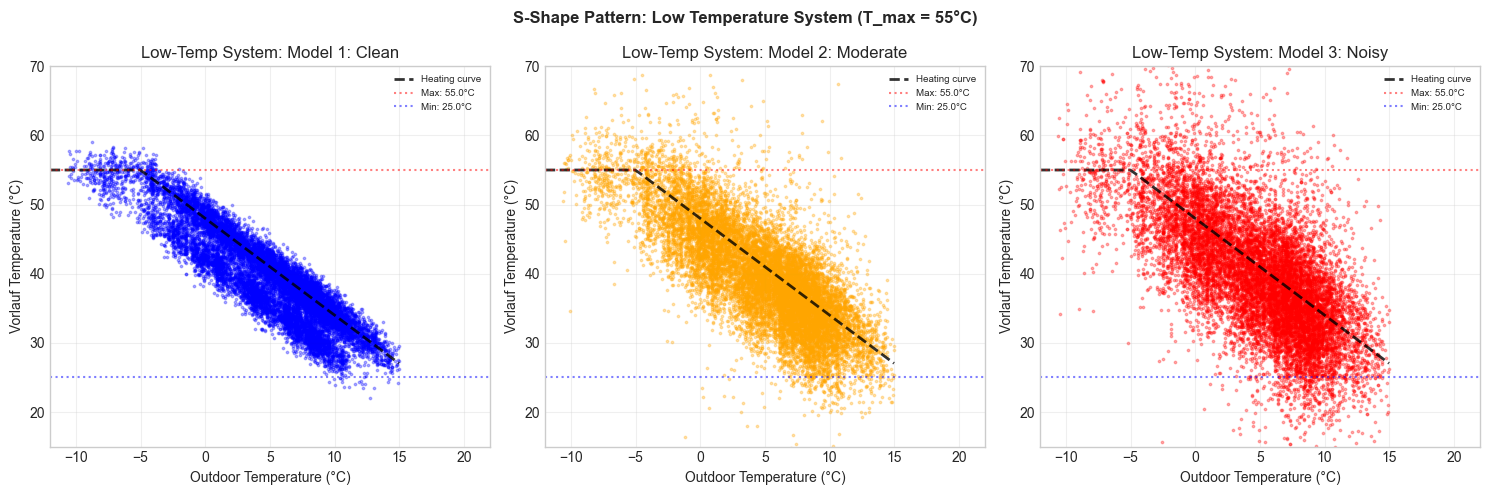

Figure saved: outputs/figures/lowtemp_models_s_shape.png


In [31]:
# Cell 25 - Low Temperature Scenario: Scatter Plots (S-Shape)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models_lt = [
    ("t_vorlauf_lowtemp_m1", "Model 1: Clean", "blue"),
    ("t_vorlauf_lowtemp_m2", "Model 2: Moderate", "orange"),
    ("t_vorlauf_lowtemp_m3", "Model 3: Noisy", "red"),
]

for ax, (col, title, color) in zip(axes, models_lt):
    mask = df[col].notna()
    
    # Scatter plot
    ax.scatter(df.loc[mask, "t_outdoor"], df.loc[mask, col], 
               alpha=0.3, s=3, c=color)
    
    # Reference lines (theoretical curves with clamping)
    t_out_range = np.linspace(-12, 18, 100)
    t_vor_day = [calculate_vorlauf_low_temp(t, t_room=CONFIG_LOW_TEMP["t_room_day"]) 
                 for t in t_out_range]
    ax.plot(t_out_range, t_vor_day, 'k--', linewidth=2, alpha=0.8, label="Heating curve")
    
    # Highlight clamping zones
    ax.axhline(y=CONFIG_LOW_TEMP["t_vorlauf_max"], color="red", linestyle=":", 
               alpha=0.5, label=f"Max: {CONFIG_LOW_TEMP['t_vorlauf_max']}°C")
    ax.axhline(y=CONFIG_LOW_TEMP["t_vorlauf_min"], color="blue", linestyle=":", 
               alpha=0.5, label=f"Min: {CONFIG_LOW_TEMP['t_vorlauf_min']}°C")
    
    ax.set_xlabel("Outdoor Temperature (°C)")
    ax.set_ylabel("Vorlauf Temperature (°C)")
    ax.set_title(f"Low-Temp System: {title}")
    ax.set_xlim(-12, 22)
    ax.set_ylim(15, 70)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right", fontsize=7)

plt.suptitle("S-Shape Pattern: Low Temperature System (T_max = 55°C)", fontweight="bold")
plt.tight_layout()
plt.savefig(f"{output_dir}/lowtemp_models_s_shape.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Figure saved: {output_dir}/lowtemp_models_s_shape.png")


## 11. Scenario Comparison

Side-by-side comparison of the original (75°C max) and low-temperature (55°C max) scenarios.


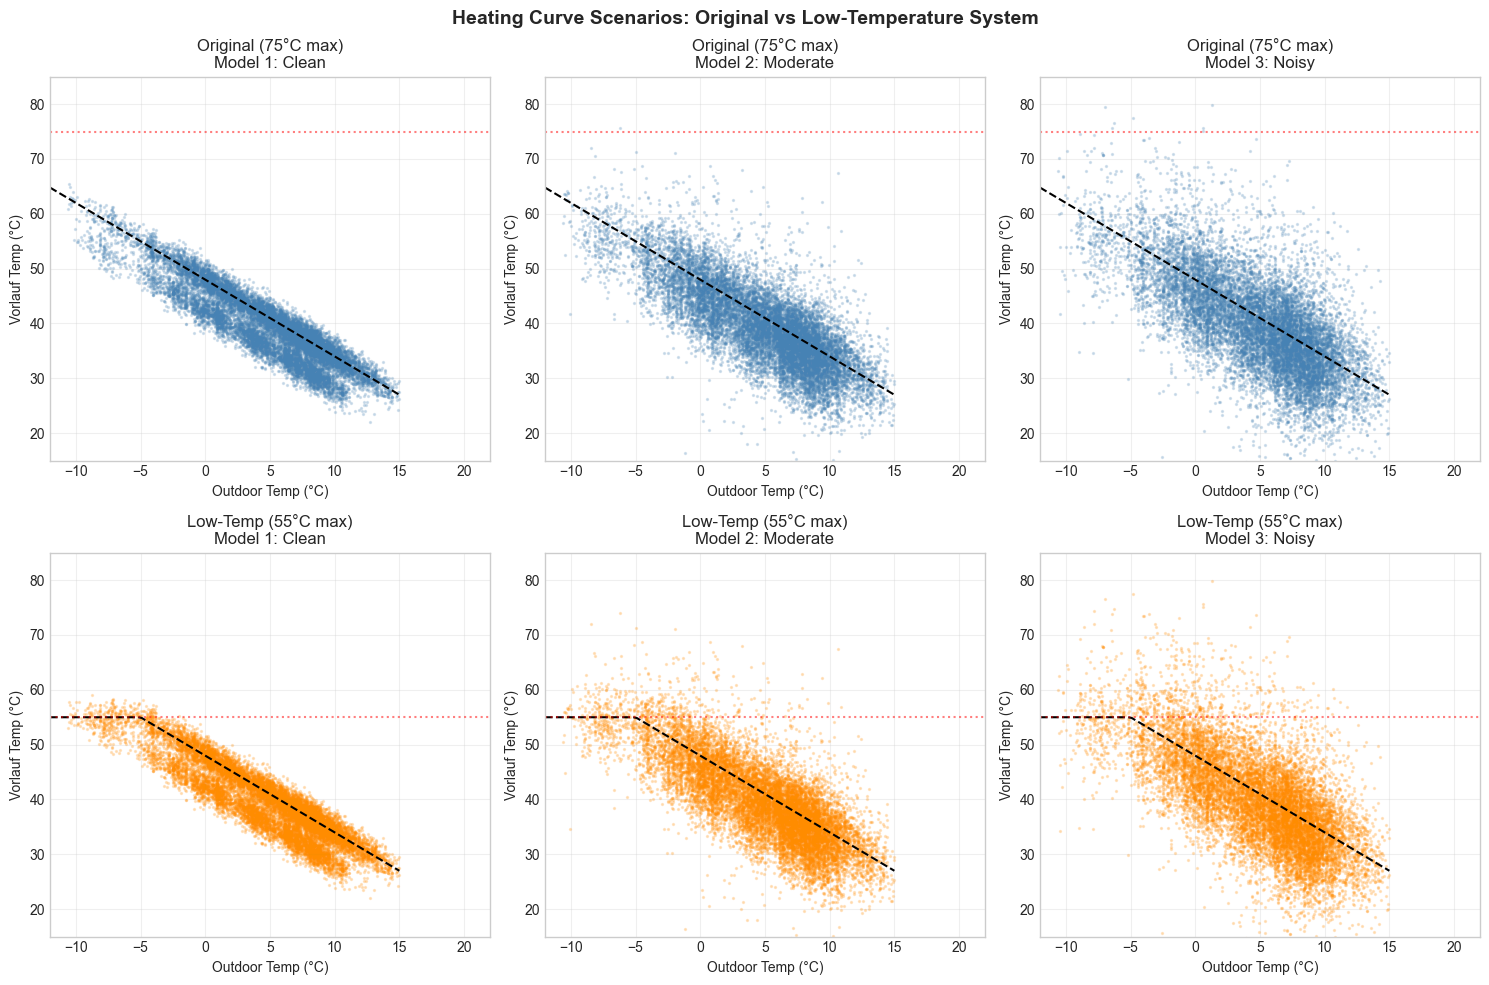

Figure saved: outputs/figures/scenario_comparison.png


In [32]:
# Cell 26 - Scenario Comparison: Original vs Low-Temp

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Top row: Original scenario (75°C max)
models_orig = [
    ("t_vorlauf_model1", "Model 1: Clean"),
    ("t_vorlauf_model2", "Model 2: Moderate"),
    ("t_vorlauf_model3", "Model 3: Noisy"),
]

for ax, (col, title) in zip(axes[0], models_orig):
    mask = df[col].notna()
    ax.scatter(df.loc[mask, "t_outdoor"], df.loc[mask, col], alpha=0.2, s=2, c="steelblue")
    t_out_range = np.linspace(-12, 15, 100)
    t_vor = [calculate_vorlauf(t, t_room=CONFIG["t_room_day"]) for t in t_out_range]
    ax.plot(t_out_range, t_vor, 'k--', linewidth=1.5)
    ax.axhline(y=CONFIG["t_vorlauf_max"], color="red", linestyle=":", alpha=0.5)
    ax.set_xlabel("Outdoor Temp (°C)")
    ax.set_ylabel("Vorlauf Temp (°C)")
    ax.set_title(f"Original (75°C max)\n{title}")
    ax.set_xlim(-12, 22)
    ax.set_ylim(15, 85)
    ax.grid(True, alpha=0.3)

# Bottom row: Low-temp scenario (55°C max)
models_lt = [
    ("t_vorlauf_lowtemp_m1", "Model 1: Clean"),
    ("t_vorlauf_lowtemp_m2", "Model 2: Moderate"),
    ("t_vorlauf_lowtemp_m3", "Model 3: Noisy"),
]

for ax, (col, title) in zip(axes[1], models_lt):
    mask = df[col].notna()
    ax.scatter(df.loc[mask, "t_outdoor"], df.loc[mask, col], alpha=0.2, s=2, c="darkorange")
    t_out_range = np.linspace(-12, 15, 100)
    t_vor = [calculate_vorlauf_low_temp(t, t_room=CONFIG_LOW_TEMP["t_room_day"]) for t in t_out_range]
    ax.plot(t_out_range, t_vor, 'k--', linewidth=1.5)
    ax.axhline(y=CONFIG_LOW_TEMP["t_vorlauf_max"], color="red", linestyle=":", alpha=0.5)
    ax.set_xlabel("Outdoor Temp (°C)")
    ax.set_ylabel("Vorlauf Temp (°C)")
    ax.set_title(f"Low-Temp (55°C max)\n{title}")
    ax.set_xlim(-12, 22)
    ax.set_ylim(15, 85)
    ax.grid(True, alpha=0.3)

plt.suptitle("Heating Curve Scenarios: Original vs Low-Temperature System", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(f"{output_dir}/scenario_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Figure saved: {output_dir}/scenario_comparison.png")


## 12. Data Export

Export datasets for Sprint 2 analysis and algorithm development.


In [33]:
# Cell 27 - Export Datasets

import os

# Create data directory
data_dir = "outputs/data"
os.makedirs(data_dir, exist_ok=True)

# Select columns for export
export_cols_original = [
    "t_outdoor", "hour", "day_of_week", "month", "is_weekend", "is_night",
    "t_room_target", "t_vorlauf_ideal", 
    "t_vorlauf_model1", "t_vorlauf_model2", "t_vorlauf_model3"
]

export_cols_lowtemp = [
    "t_outdoor", "hour", "day_of_week", "month", "is_weekend", "is_night",
    "t_room_target", "t_vorlauf_lowtemp_ideal",
    "t_vorlauf_lowtemp_m1", "t_vorlauf_lowtemp_m2", "t_vorlauf_lowtemp_m3"
]

# Export original scenario
df_export_orig = df[export_cols_original].copy()
df_export_orig.to_csv(f"{data_dir}/heating_curve_original.csv")
df_export_orig.to_pickle(f"{data_dir}/heating_curve_original.pkl")

# Export low-temp scenario
df_export_lt = df[export_cols_lowtemp].copy()
df_export_lt.to_csv(f"{data_dir}/heating_curve_lowtemp.csv")
df_export_lt.to_pickle(f"{data_dir}/heating_curve_lowtemp.pkl")

# Export configuration
config_export = {
    "original": CONFIG,
    "low_temp": CONFIG_LOW_TEMP,
    "noise_models": NOISE_CONFIG,
    "data_source": {
        "api": "Open-Meteo Historical Weather API",
        "location": "Berlin (52.52°N, 13.41°E)",
        "period": "2023-11-01 to 2024-03-31",
        "resolution": "15 minutes"
    }
}

import json
with open(f"{data_dir}/config.json", "w") as f:
    json.dump(config_export, f, indent=2)

print("Data exported:")
print(f"  {data_dir}/heating_curve_original.csv ({len(df_export_orig)} rows)")
print(f"  {data_dir}/heating_curve_original.pkl")
print(f"  {data_dir}/heating_curve_lowtemp.csv ({len(df_export_lt)} rows)")
print(f"  {data_dir}/heating_curve_lowtemp.pkl")
print(f"  {data_dir}/config.json")


Data exported:
  outputs/data/heating_curve_original.csv (14589 rows)
  outputs/data/heating_curve_original.pkl
  outputs/data/heating_curve_lowtemp.csv (14589 rows)
  outputs/data/heating_curve_lowtemp.pkl
  outputs/data/config.json


## 13. Sprint 1 Summary

### Deliverables Completed

| Deliverable | Status | Location |
|-------------|--------|----------|
| Weather data acquisition | Complete | Open-Meteo API (Berlin 2023-24) |
| Heating curve function | Complete | `calculate_vorlauf()` |
| Night setback logic | Complete | `is_night_hour()`, `get_room_target()` |
| Noise models (3) | Complete | Model 1/2/3 with increasing noise |
| Low-temp scenario | Complete | 55°C max, S-shape pattern |
| Scatter plots | Complete | `outputs/figures/` |
| Time series plots | Complete | Daily + sample week |
| Domain validation | Complete | All benchmarks passed |
| Data export | Complete | `outputs/data/` |

### Key Findings

1. **Berlin winter 2023-24 was mild**: Mean outdoor temp 4.9°C, only 25 days below freezing
2. **Heating curve produces expected values**: 62°C Vorlauf at -10°C outdoor (validated)
3. **Night setback effect**: 5.4K reduction at 0°C outdoor (within 4-6K expected range)
4. **S-shape visible with 55°C max**: 253 records clamped at upper limit

### Next Steps (Sprint 2)

1. **model.ipynb enhancements**: Add thermal inertia, hysteresis, DHW spikes
2. **analysis.ipynb**: Develop heating curve extraction algorithm
3. **Validation**: Test algorithm on Model 1/2/3 to assess robustness

### Decisions Made

- [DEC-001](plan/DEC-001_sprint3_streamlit_app.md): Sprint 3 Streamlit application scope
- [DEC-002](plan/DEC-002_vorlauf_max_55C_scenario.md): Low-temp scenario (55°C max)


In [35]:
# Cell 28 - Final Output Summary

print("=" * 60)
print("SPRINT 1 COMPLETE: Heating Curve Simulation")
print("=" * 60)

print("\nFIGURES GENERATED:")
for fig_file in sorted(os.listdir(output_dir)):
    if fig_file.endswith(".png"):
        print(f"  - {output_dir}/{fig_file}")

print("\nDATA EXPORTED:")
for data_file in sorted(os.listdir(data_dir)):
    print(f"  - {data_dir}/{data_file}")

print("\nDATASET SUMMARY:")
print(f"  Total records: {len(df)}")
print(f"  Date range: {df.index.min().date()} to {df.index.max().date()}")
print(f"  Resolution: 15 minutes")
print(f"  Scenarios: Original (75°C max) + Low-temp (55°C max)")
print(f"  Noise models: 3 (Clean, Moderate, Noisy)")

print("\n" + "=" * 60)
print("Ready for Sprint 2: Analysis & Algorithm Development")
print("=" * 60)


SPRINT 1 COMPLETE: Heating Curve Simulation

FIGURES GENERATED:
  - outputs/figures/lowtemp_models_s_shape.png
  - outputs/figures/model_0_ideal_heating_curve.png
  - outputs/figures/models_1_2_3_comparison.png
  - outputs/figures/scenario_comparison.png
  - outputs/figures/summary_combined.png
  - outputs/figures/timeseries_daily_overview.png
  - outputs/figures/timeseries_sample_week.png

DATA EXPORTED:
  - outputs/data/config.json
  - outputs/data/heating_curve_lowtemp.csv
  - outputs/data/heating_curve_lowtemp.pkl
  - outputs/data/heating_curve_original.csv
  - outputs/data/heating_curve_original.pkl

DATASET SUMMARY:
  Total records: 14589
  Date range: 2023-11-01 to 2024-03-31
  Resolution: 15 minutes
  Scenarios: Original (75°C max) + Low-temp (55°C max)
  Noise models: 3 (Clean, Moderate, Noisy)

Ready for Sprint 2: Analysis & Algorithm Development
